In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
#warnings.filterwarnings('ignore')
import random

In [6]:
# Settings and configurations
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor'] = '#333F4B'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.color'] = '#333F4B'
plt.rcParams['ytick.color'] = '#333F4B'

In [7]:
# Load data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [8]:
# Preprocess tags and genres
movies_tags = pd.merge(movies, tags, on='movieId', how='left')
movies_tags['tag'] = movies_tags['tag'].fillna('')
grouped_tags = movies_tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
movies = movies.merge(grouped_tags, on='movieId', how='left')
movies['tag'] = movies['tag'].fillna('')
movies['genres_cleaned'] = movies['genres'].apply(lambda x: x.lower().replace('|', ' '))

In [9]:
# TF-IDF vectorization for tags and genres
tfidf_tags = TfidfVectorizer(stop_words='english')
tfidf_genres = TfidfVectorizer()
tfidf_matrix_tags = tfidf_tags.fit_transform(movies['tag'])
tfidf_matrix_genres = tfidf_genres.fit_transform(movies['genres_cleaned'])
tfidf_feature_names = tfidf_tags.get_feature_names_out()

# Cosine similarity calculation for tags and genres
cosine_sim_tags = cosine_similarity(tfidf_matrix_tags)
cosine_sim_genres = cosine_similarity(tfidf_matrix_genres)

user_ratings_pivot = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
cosine_sim_users = cosine_similarity(user_ratings_pivot)


# Indices mapping from movieId to matrix indices
indices = pd.Series(index=movies['movieId'], data=movies.index)
user_indices = pd.Series(index=user_ratings_pivot.index, data=user_ratings_pivot.index)

In [10]:
# print("\n",tfidf_matrix_tags)
# print("\n",tfidf_matrix_genres)
# print("\n",tfidf_feature_names)

# print("\n",cosine_sim_tags)
# print("\n",cosine_sim_genres)
# print("\n",cosine_sim_users)

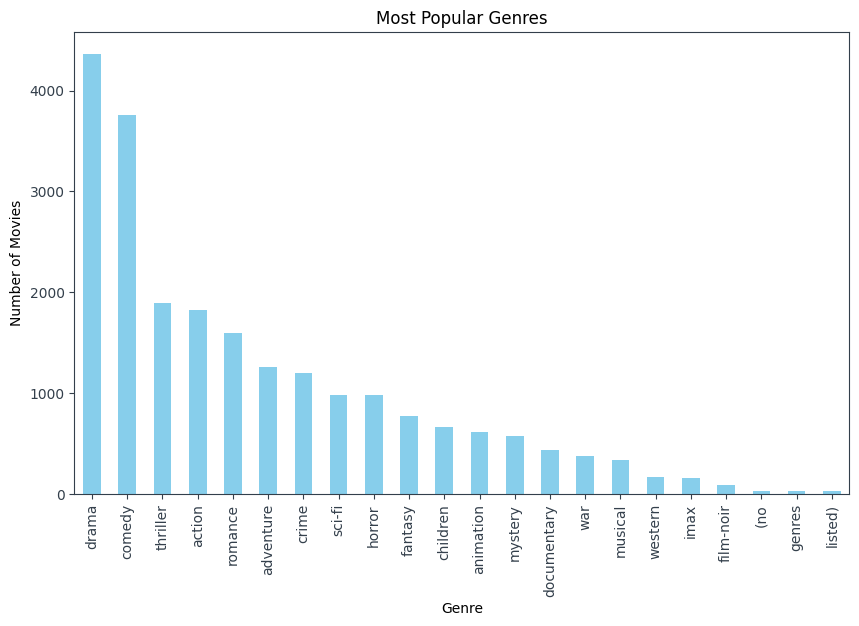

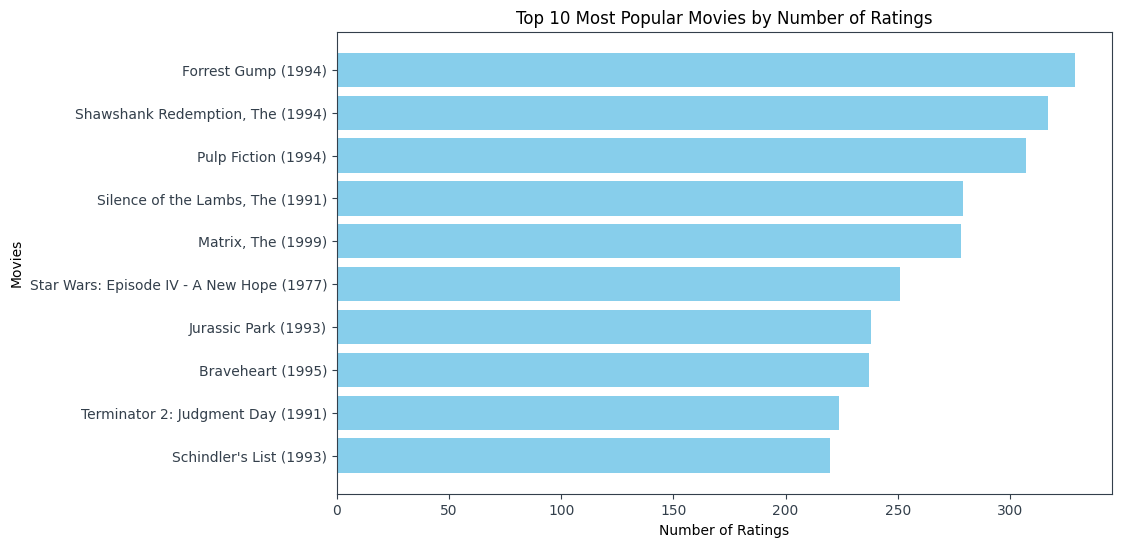

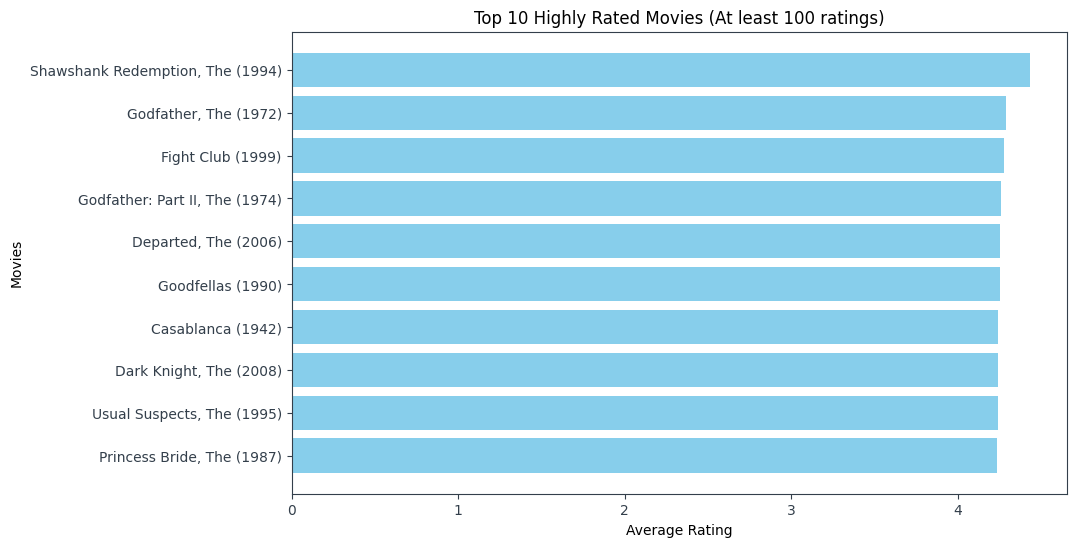

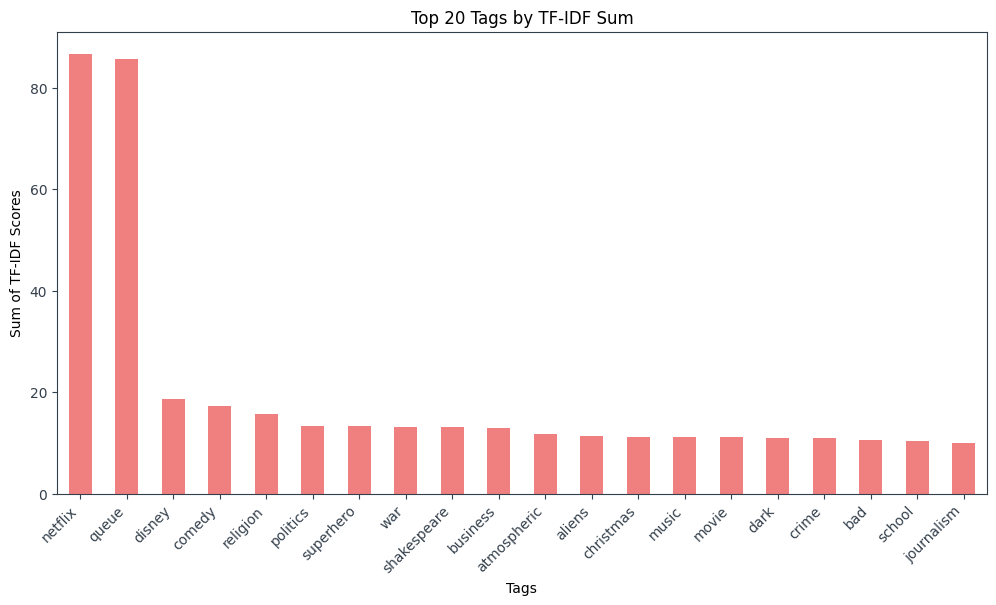

In [11]:
# Visualization functions
def plot_popular_genres():
    all_genres = np.concatenate(movies['genres'].str.replace('|', ' ').str.lower().str.split())
    genres_counts = pd.Series(all_genres).value_counts()
    plt.figure(figsize=(10, 6))
    genres_counts.plot(kind='bar', color='skyblue')
    plt.title('Most Popular Genres')
    plt.xlabel('Genre')
    plt.ylabel('Number of Movies')
    plt.show()

def plot_popular_movies():
    ratings_count = ratings['movieId'].value_counts().rename_axis('movieId').reset_index(name='counts')
    popular_movies = ratings_count.merge(movies, on='movieId').head(10)
    plt.figure(figsize=(10, 6))
    plt.barh(popular_movies['title'], popular_movies['counts'], color='skyblue')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Movies')
    plt.title('Top 10 Most Popular Movies by Number of Ratings')
    plt.gca().invert_yaxis()
    plt.show()

def plot_highly_rated_movies():
    average_ratings = ratings.groupby('movieId').agg({'rating': 'mean', 'userId': 'count'}).rename(columns={'userId': 'rating_count'})
    highly_rated_movies = average_ratings[average_ratings['rating_count'] >= 100].sort_values('rating', ascending=False).head(10)
    highly_rated_movies = highly_rated_movies.merge(movies, on='movieId')
    plt.figure(figsize=(10, 6))
    plt.barh(highly_rated_movies['title'], highly_rated_movies['rating'], color='skyblue')
    plt.xlabel('Average Rating')
    plt.ylabel('Movies')
    plt.title('Top 10 Highly Rated Movies (At least 100 ratings)')
    plt.gca().invert_yaxis()
    plt.show()

def plot_most_common_tags():
    #Sum the TF-IDF values for each tag across all movies
    tag_sums = np.sum(tfidf_matrix_tags, axis=0)
    # Create a dataframe for tags and their summed TF-IDF scores
    tag_sum_df = pd.DataFrame(tag_sums, columns=tfidf_feature_names).transpose()
    tag_sum_df.columns = ['sum']
    tag_sum_df = tag_sum_df.sort_values(by='sum', ascending=False).head(20)

    #Plotting the most common tags
    plt.figure(figsize=(12, 6))
    tag_sum_df['sum'].plot(kind='bar', color='lightcoral')
    plt.title('Top 20 Tags by TF-IDF Sum')
    plt.xlabel('Tags')
    plt.ylabel('Sum of TF-IDF Scores')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Execute visualizations
plot_popular_genres()
plot_popular_movies()
plot_highly_rated_movies()
plot_most_common_tags()

In [12]:
# Combined recommendation function based on a movie
def get_recommendations_by_movie(movieId, top_n=10):
    if movieId not in indices:
        return "Movie ID not found in dataset."
    idx = indices[movieId]
    # Calculate tag and genre similarities separately
    sim_scores_tags = list(enumerate(cosine_sim_tags[idx]))
    sim_scores_genres = list(enumerate(cosine_sim_genres[idx]))

    # Weighted average of tag and genre similarities (adjust weights as needed)
    sim_scores = [(i, 0.6 * score_tags + 0.4 * score_genres) for (i, score_tags), (_, score_genres) in zip(sim_scores_tags, sim_scores_genres)]

    # Sort scores and exclude the movie itself from the recommendations
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [sim_score for sim_score in sim_scores if sim_score[0] != idx][:top_n]  # Exclude the movie itself
    movie_indices = [i[0] for i in sim_scores]

    return movies.loc[movie_indices, ['movieId', 'title', 'genres']].reset_index(drop=True)

In [13]:
# User-based recommendations function
def get_user_recommendations(userid, top_n=10):
    if userid not in ratings['userId'].values:
        return "User ID not found in dataset."
    user_ratings = ratings[ratings['userId'] == userid].copy()
    user_ratings['weighted_avg'] = user_ratings.apply(lambda x: np.mean(cosine_sim_genres[indices[x['movieId']]] * x['rating']), axis=1)
    top_movies = user_ratings.sort_values('weighted_avg', ascending=False).head(top_n)['movieId']
    return movies[movies['movieId'].isin(top_movies)][['movieId', 'title', 'genres']].reset_index(drop=True)

In [14]:
# Recommendations based on similar users
def get_user_user_recommendations(userid, top_n=5):
    if userid not in user_indices:
        return "User ID not found in dataset."
    idx = user_indices[userid]
    sim_scores = list(enumerate(cosine_sim_users[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]  # Top 5 similar users, excluding self
    similar_users = [i[0] for i in sim_scores]
    recommended_movies = {}
    for user in similar_users:
        user_movies = ratings[(ratings['userId'] == user) & ~ratings['movieId'].isin(ratings[ratings['userId'] == userid]['movieId'])]
        top_user_movies = user_movies.sort_values('rating', ascending=False).head(5)['movieId'].tolist()
        for movie in top_user_movies:
            if movie in recommended_movies:
                recommended_movies[movie] += 1  # Count appearances for ranking
            else:
                recommended_movies[movie] = 1
    # Sort movies by the number of recommendations and return top N
    recommended_sorted = sorted(recommended_movies.items(), key=lambda x: x[1], reverse=True)
    top_movie_ids = [movie[0] for movie in recommended_sorted][:top_n]
    return movies[movies['movieId'].isin(top_movie_ids)][['movieId', 'title', 'genres']].reset_index(drop=True)

In [15]:
# Plot User 10's favorite movie genres
def plot_user_preferences(userid):
    user_ratings = ratings[ratings['userId'] == userid]
    rated_movies = movies[movies['movieId'].isin(user_ratings['movieId'])]
    rated_movies = rated_movies.join(user_ratings.set_index('movieId'), on='movieId')

    # Initializing an empty dictionary to store cumulative ratings for each genre
    genre_ratings_dict = {}

    # Calculating weighted ratings for each genre
    for index, row in rated_movies.iterrows():
        genres = row['genres'].split('|')
        for genre in genres:
            if genre in genre_ratings_dict:
                genre_ratings_dict[genre] += row['rating']
            else:
                genre_ratings_dict[genre] = row['rating']

    # Transforming the dictionary into a DataFrame for easier plotting
    genre_ratings = pd.DataFrame(list(genre_ratings_dict.items()), columns=['Genre', 'TotalRating'])
    genre_ratings.sort_values('TotalRating', ascending=False, inplace=True)

    # Plotting the genres and their cumulative ratings
    plt.figure(figsize=(10, 5))
    plt.bar(genre_ratings['Genre'], genre_ratings['TotalRating'], color='skyblue')
    plt.title(f'User {userid} Favorite Genres Based on Ratings')
    plt.xlabel('Genres')
    plt.ylabel('Cumulative Rating')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# List top 5 movies for user
def list_top_movies_for_user(userid, top_n=5):
    if userid not in ratings['userId'].values:
        return "User ID not found in dataset."
    top_movies = ratings[ratings['userId'] == userid].sort_values('rating', ascending=False).head(top_n)
    return movies[movies['movieId'].isin(top_movies['movieId'])][['movieId', 'title', 'genres']].reset_index(drop=True)

Enter User ID: 20


Top 5 Movies for User 20 :

   movieId                                   title  \
0       48                       Pocahontas (1995)   
1      364                   Lion King, The (1994)   
2      551  Nightmare Before Christmas, The (1993)   
3      588                          Aladdin (1992)   
4      594  Snow White and the Seven Dwarfs (1937)   

                                            genres  
0         Animation|Children|Drama|Musical|Romance  
1  Adventure|Animation|Children|Drama|Musical|IMAX  
2               Animation|Children|Fantasy|Musical  
3      Adventure|Animation|Children|Comedy|Musical  
4         Animation|Children|Drama|Fantasy|Musical  


Recommendations based on user ratings (for user ID 20):

   movieId                         title  \
0     1907                  Mulan (1998)   
1     2300         Producers, The (1968)   
2     3410             Soft Fruit (1999)   
3     3897          Almost Famous (2000)   
4     3967           Billy Ell

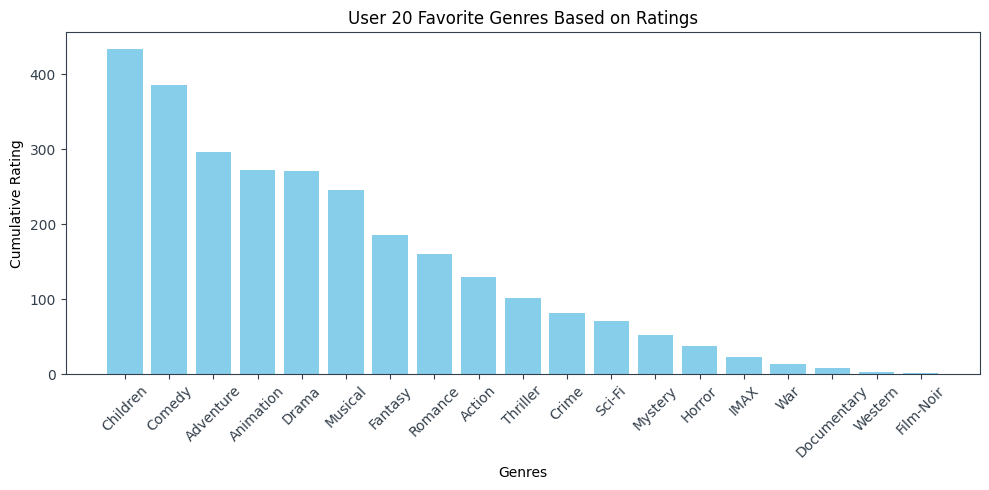

In [16]:
# Example usage
if __name__ == "__main__":
  user_id = int(input("Enter User ID: "))
  top_movies_user = list_top_movies_for_user(user_id)
  print(f"\n\nTop 5 Movies for User {user_id} :\n")
  print(top_movies_user)

  print(f"\n\nRecommendations based on user ratings (for user ID {user_id}):\n")
  print(get_user_recommendations(user_id))
  print(f"\n\nRecommendations based on other similar user ratings (for user ID {user_id}):\n")
  print(get_user_user_recommendations(user_id))

  # Select one random movie from the top movies list
  if not top_movies_user.empty:
      random_movie_id = random.choice(top_movies_user['movieId'].tolist())
      movie_title = movies.loc[movies['movieId'] == random_movie_id, 'title'].iloc[0]

  print(f"\n\nRecommendations based on movie similarity (for movie ID {random_movie_id}: {movie_title}):\n")
  print(get_recommendations_by_movie(random_movie_id))
  # Plotting user user_id's genre preferences
  plot_user_preferences(user_id)